In [1]:
import pandas as pd
import numpy as np
from pickleshare import PickleShareDB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import time
import tracemalloc

In [2]:
# Pour garantir la reproductibilité
np.random.seed(42)  # Pour numpy

## Chargement des données

In [3]:
db = PickleShareDB('../prep_data/kity')

In [4]:
# Chargement des données de classification binaire
X_train_resampled_binary = db['binary_X_train_resampled']
y_train_resampled_binary = db['binary_y_train_resampled']
X_test_binary = db['binary_X_test']
y_test_binary = db['binary_y_test']

# Chargement des données de classification multi-classes
X_train_resampled_multiclass = db['multiclass_X_train_resampled']
y_train_resampled_multiclass = db['multiclass_y_train_resampled']
X_test_multiclass = db['multiclass_X_test']
y_test_multiclass = db['multiclass_y_test']

# Chargement du mapping des étiquettes pour la classification multi-classes
# Ce dictionnaire associe les étiquettes textuelles (e.g., 'normal', 'DoS') à des valeurs numériques
label_mapping_network = db['label_mapping_network']

## Initialisation du modèle

In [5]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

## Entraînement du modèle et évaluation - Classification binaire

In [6]:
# Mesurer le temps et la mémoire pour l'entraînement
tracemalloc.start()
start_fit_time = time.time()

xgb_model.fit(X_train_resampled_binary, y_train_resampled_binary)

fit_time = time.time() - start_fit_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
fit_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [7]:
# Mesurer le temps et la mémoire pour la prediction
tracemalloc.start()
start_predict_time = time.time()

# Prédire les étiquettes sur l'ensemble de test
y_pred = xgb_model.predict(X_test_binary)
predict_time = time.time() - start_predict_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
predict_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

### Évaluation

#### Métriques de classification

In [8]:
cm = confusion_matrix(y_test_binary, y_pred)
TN, FP, FN, TP = cm.ravel()

# Métriques pour les données équilibrées
precision = precision_score(y_test_binary, y_pred, average='binary')
recall = recall_score(y_test_binary, y_pred, average='binary')
tnr = TN / (TN + FP) if (TN + FP) != 0 else 0
fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
accuracy = accuracy_score(y_test_binary, y_pred)

# Métriques pour les données déséquilibrées
f1 = f1_score(y_test_binary, y_pred, average='binary')
balanced_acc = balanced_accuracy_score(y_test_binary, y_pred)
mcc = matthews_corrcoef(y_test_binary, y_pred)

results_XGBoost_label_n = {
    'data': 'NETW',
    'model_type': 'XGBoost',
    'attack_type': 'labeln',
    'confusion_matrix': cm,
    'precision': precision,
    'recall': recall,
    'tnr': tnr,
    'fpr': fpr,
    'accuracy': accuracy,
    'f1': f1,
    'balanced_accuracy': balanced_acc,
    'mcc': mcc,
    'fit_time': fit_time,
    'predict_time': predict_time,
    'fit_memory_usage': fit_memory_usage,
    'predict_memory_usage': predict_memory_usage
}

In [9]:
# Afficher les résultats
print("Évaluation complète du modèle:")
for metric, value in results_XGBoost_label_n.items():
    print(f"{metric}: {value}")

Évaluation complète du modèle:
data: NETW
model_type: XGBoost
attack_type: labeln
confusion_matrix: [[63374   106]
 [19120 25210]]
precision: 0.9958129246326434
recall: 0.568689375140988
tnr: 0.9983301827347196
fpr: 0.0016698172652804032
accuracy: 0.8216677488173639
f1: 0.7239468167590386
balanced_accuracy: 0.7835097789378538
mcc: 0.6581981223364844
fit_time: 1.9574434757232666
predict_time: 0.14683055877685547
fit_memory_usage: 2.5016250610351562
predict_memory_usage: 0.9559240341186523


##### Matrice de confusion 

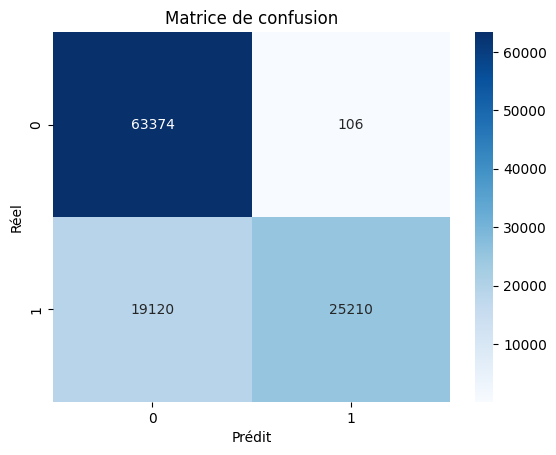

In [10]:
# Matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### Sauvegarder les resultats

In [11]:
# sauvegarder dans PickleShareDB
db['NETW_results_XGBoost_labeln'] = results_XGBoost_label_n

## Entraînement du modèle et évaluation - Classification multi-classes

In [12]:
ordered_classes = ['normal', 'DoS','physical fault', 'MITM', 'anomaly']
nb_class = 5

In [13]:
# Mesurer le temps et la mémoire pour l'entraînement
tracemalloc.start()
start_fit_time = time.time()

xgb_model.fit(X_train_resampled_multiclass, y_train_resampled_multiclass)

fit_time = time.time() - start_fit_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
fit_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
# Mesurer le temps et la mémoire pour la prediction
tracemalloc.start()
start_predict_time = time.time()

# Prédire les étiquettes sur l'ensemble de test
y_pred = xgb_model.predict(X_test_multiclass)
predict_time = time.time() - start_predict_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
predict_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

In [15]:
reverse_label_mapping = {v: k for k, v in label_mapping_network.items()}

### Évaluation

#### Métriques de classification

In [16]:
cm = confusion_matrix(y_test_multiclass, y_pred)

# Dictionnaire pour stocker les résultats de chaque classe
class_results = {}

for class_label in range(nb_class):
    # Extraire la matrice de confusion pour la classe spécifique
    TP = cm[class_label, class_label]
    FP = sum(cm[:, class_label]) - TP
    FN = sum(cm[class_label, :]) - TP
    TN = cm.sum() - (TP + FP + FN)

    # Calcul des métriques pour chaque classe
    precision = precision_score(y_test_multiclass, y_pred, average=None)[class_label]
    recall_tpr = recall_score(y_test_multiclass, y_pred, average=None)[class_label]
    tnr = TN / (TN + FP) if (TN + FP) != 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test_multiclass, y_pred, average=None)[class_label]
    balanced_acc = (recall_tpr + tnr) / 2
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) != 0 else 0


# Stocker les résultats dans le dictionnaire
    class_results[class_label] = {
        'data': 'NETW',
        'model_type': 'XGBoost',
        'attack_type': reverse_label_mapping[class_label],
        'confusion_matrix': cm,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP,
        'precision': precision,
        'recall': recall_tpr,
        'f1': f1,
        'balanced_accuracy': balanced_acc,
        'mcc': mcc,
        'tnr': tnr,
        'fpr': fpr,
        'accuracy': accuracy,
        'fit_time': fit_time,
        'predict_time': predict_time,
        'fit_memory_usage': fit_memory_usage,
        'predict_memory_usage': predict_memory_usage
    }

# Afficher ou enregistrer les résultats pour chaque classe
print(class_results)

c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{0: {'data': 'NETW', 'model_type': 'XGBoost', 'attack_type': 'normal', 'confusion_matrix': array([[63471,     8,     0,     1,     0],
       [  818, 24989,     0,     0,     1],
       [ 7742,     1,     0,     0,     0],
       [10710,     1,     0,    66,     0],
       [    0,     0,     0,     0,     2]], dtype=int64), 'TN': 25060, 'FP': 19270, 'FN': 9, 'TP': 63471, 'precision': 0.76710457935002, 'recall': 0.9998582230623818, 'f1': 0.8681516334862981, 'balanced_accuracy': 0.7825819425711187, 'mcc': 0.658283301761818, 'tnr': 0.5653056620798557, 'fpr': 0.4346943379201444, 'accuracy': 0.8211761432149152, 'fit_time': 18.42064118385315, 'predict_time': 0.3343052864074707, 'fit_memory_usage': 3.924409866333008, 'predict_memory_usage': 2.903407096862793}, 1: {'data': 'NETW', 'model_type': 'XGBoost', 'attack_type': 'DoS', 'confusion_matrix': array([[63471,     8,     0,     1,     0],
       [  818, 24989,     0,     0,     1],
       [ 7742,     1,     0,     0,     0],
       [10710,   

c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# vérif
print(precision_score(y_test_multiclass, y_pred, average=None))
for i in range(nb_class):
    print(f"Résultats pour la classe {i}: {class_results[i]['precision']}")
    print(f"avec calcul : {class_results[i]['TP'] / (class_results[i]['TP'] + class_results[i]['FP'])}")

[0.76710458 0.99959998 0.         0.98507463 0.66666667]
Résultats pour la classe 0: 0.76710457935002
avec calcul : 0.76710457935002
Résultats pour la classe 1: 0.99959998399936
avec calcul : 0.99959998399936
Résultats pour la classe 2: 0.0
avec calcul : nan
Résultats pour la classe 3: 0.9850746268656716
avec calcul : 0.9850746268656716
Résultats pour la classe 4: 0.6666666666666666
avec calcul : 0.6666666666666666


c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\charl\AppData\Local\Temp\ipykernel_15464\2830791748.py:5: RuntimeWarning: invalid value encountered in scalar divide
  print(f"avec calcul : {class_results[i]['TP'] / (class_results[i]['TP'] + class_results[i]['FP'])}")


In [18]:
tp = class_results[1]['TP']
fn = class_results[1]['FN']
print("test tpr", tp / (tp + fn))
print(class_results[1]['recall'])

test tpr 0.9682656540607564
0.9682656540607564


#### Matrice de confusion 

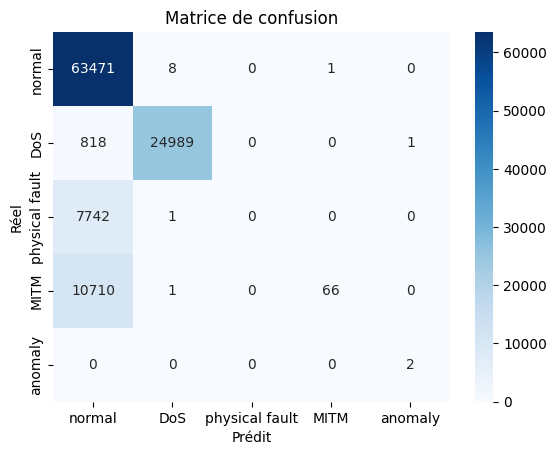

In [19]:
# Matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_classes, yticklabels=ordered_classes)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### Sauvegarder les resultats

In [20]:
# sauvegarder les données 

for i in range(1, nb_class):
    class_results[i]['model'] = f'XGBoost - label - {reverse_label_mapping[i]}'
    db[f'NETW_results_XGBoost_{reverse_label_mapping[i]}'] = class_results[i]